In [1]:
import Gym
import Random
import Flux
import Flux: Chain, Dense, relu, tanh, glorot_uniform
import ProgressBars: ProgressBar
using Plots
using Statistics

const F = Float32

Float32

# Advantage Actor-Critic (A2C) Method

In [2]:
mutable struct AgentHistory
    nS::Int
    nA::Int
    γ::F
    states::Array{F}
    actions::Array{Int}
    rewards::Array{F}
end
AgentHistory(nS, nA, γ) = AgentHistory(nS, nA, γ, zeros(0),zeros(Int, 0),zeros(0))

AgentHistory

In [3]:
function compute_discounted_returns(rewards; γ=0.95)
    N = length(rewards)
    discount_exps = γ.^(1:N)
    rev_discounted_rewards = reverse(discount_exps .* rewards)
    cum_discounted_rewards = reverse(cumsum(rev_discounted_rewards, dims=1))
    R = cum_discounted_rewards ./ discount_exps
    return (R .- mean(R)) ./ (std(R) + F(1e-10)) #speeds up training a lot
end



compute_discounted_returns (generic function with 1 method)

In [4]:
function sample_action(probs)
    probs = Array(probs)
    cprobs = cumsum(probs, dims=1)
    sampled = cprobs .> rand() 
    sampled_action = mapslices(argmax, sampled, dims=1)[1]
    return sampled_action
end

sample_action(Vector(1:10)/55)

10

In [5]:
function init_ac_weights(hidden_units; x_dim=4, y_dim=2)
    layers = []
    x = x_dim
    for y in [hidden_units...]
        push!(layers, Dense(x, y, relu; bias=true, init=glorot_uniform))
        x = y
    end
    push!(layers, Dense(x, y_dim; bias=true, init=glorot_uniform)) # Prob actions
    push!(layers, Dense(x, 1; bias=true, init=glorot_uniform)) # Value function
    return layers
end

w_ = init_ac_weights([1,3,4])

5-element Vector{Any}:
 Dense(4, 1, relu)   # 5 parameters
 Dense(1, 3, relu)   # 6 parameters
 Dense(3, 4, relu)   # 16 parameters
 Dense(4, 2)         # 10 parameters
 Dense(4, 1)         # 5 parameters

In [13]:
function predict(w, x)
    x = float.(x)
    shared_output = x
    shared_output = Chain(w[1:end-2]...)(x)
    prob_act_pre_scale = w[end-1](shared_output)
    value = w[end](shared_output)
    return prob_act_pre_scale, value
end

predict (generic function with 1 method)

In [17]:
L2fn(x) = sum(x .* x)

function ac_loss(w, agent_history; lam_par=1)
    nS, nA = agent_history.nS, agent_history.nA
    M = length(agent_history.states) ÷ nS
    states = reshape(agent_history.states, nS, M)
    R = compute_discounted_returns(agent_history.rewards, γ=agent_history.γ)
    
    p, V = predict(w, states)
    V = vec(V)
    A = R .- V   # advantage  
    inds = agent_history.actions + nA * (0:M-1)
    lsp = Flux.logsoftmax(p, dims=1)[inds] # lsp is a vector
    return -sum(lsp .* A) + L2fn(A) * lam_par
end

ac_loss (generic function with 1 method)

In [188]:
import ReinforcementLearning
import StableRNGs

function main_a2c(env_fn;
    nS = 4, 
    nA = 2,
    hidden = [16, 8], # width inner layers
    lr = 1e-3,
    γ = 0.99, #discount rate
    episodes = 3000,
    render = true,
    seed = 5,
    infotime = 50
)
    seed > 0 && Random.seed!(seed)
    env = env_fn(; continuous=false, rng = StableRNGs.StableRNG(hash(seed)))
    ac_weights = init_ac_weights(hidden, x_dim=nS, y_dim=nA)
    opt = Flux.ADAM(lr)
    avgreward = 0
    avgrewards = []
    for episode=1:episodes
        ReinforcementLearning.RLBase.reset!(env)
        episode_rewards = 0
        history = AgentHistory(nS, nA, γ)
        state = env.state
        for t=1:10000
            p, V = predict(ac_weights, state)
            p = Flux.softmax(p, dims=1)
            action = sample_action(p)
            reward = ReinforcementLearning.RLBase.reward(env)
            append!(history.states, float(state))
            push!(history.actions, action)
            push!(history.rewards, reward)
            env(action)
            state = env.state
            episode_rewards += reward
            env.done && break
        end
        avgreward = 0.1 * episode_rewards + avgreward * 0.9
        push!(avgrewards, avgreward)
        params_ac = Flux.params(ac_weights)
        grads = Flux.gradient(() -> ac_loss(ac_weights, history), Flux.params(ac_weights))
        Flux.update!(opt, params_ac, grads) 
    end

    return ac_weights, avgrewards
end

main_a2c (generic function with 1 method)

https://github.com/MZayed47/A3C_Agent/blob/main/A3C-Cartpole/cartpole.py

## Asynchronous Advantage Actor Critic (A3C)

In [201]:
using ReinforcementLearning
import StableRNGs
N_THREADS = Threads.nthreads()
weights_lock = Threads.SpinLock()

function main_a3c(env_fn;
    nS = 4, 
    nA = 2,
    hidden = [16, 8], # width inner layers
    lr = 1e-3,
    γ = 0.99, #discount rate,
    num_agents = 3,
    time_step_update = 10,
    episodes = 3000,
    render = true,
    seed = 5,
    infotime = 50
)
    seed > 0 && Random.seed!(seed)
    shared_ac_weights = init_ac_weights(hidden, x_dim=nS, y_dim=nA)
    prev_rewards = [0.0 for _ in 1:num_agents]
    shared_avgrewards = [0.0 for _ in 1:episodes]
    
    Threads.@threads for agent_id in 1:num_agents
        params_shared_ac_weights = Flux.params(shared_ac_weights)
        opt = Flux.ADAM(lr)
        env_thread = env_fn(; continuous=false, rng = StableRNGs.StableRNG(hash(seed)))
        ac_weights_thread = shared_ac_weights
        params_thread_ac_weights = Flux.params(ac_weights_thread)
        for episode=1:episodes
            ac_weights_thread = shared_ac_weights
            reset!(env_thread)
            state = env_thread.state
            history = AgentHistory(nS, nA, γ)
            for t=1:10000
                p, V = predict(ac_weights_thread, state)
                p = Flux.softmax(p, dims=1)
                action = sample_action(p)
                append!(history.states, float(state))
                reward = RLBase.reward(env_thread)
                push!(history.actions, action)
                push!(history.rewards, reward)
                env_thread(action)
                state = env_thread.state
                env_thread.done && break
            end
            avgreward = 0.1 * sum(history.rewards) + prev_rewards[agent_id] * 0.9
            prev_rewards[agent_id] = avgreward
            grads = Flux.gradient(() -> ac_loss(ac_weights_thread, history), params_thread_ac_weights)
            lock(weights_lock) do
                Flux.update!(opt, params_shared_ac_weights, grads) 
                shared_avgrewards[episode] += avgreward
            end
        end
    end
    shared_avgrewards /= num_agents
    return shared_ac_weights, shared_avgrewards
end


main_a3c (generic function with 1 method)

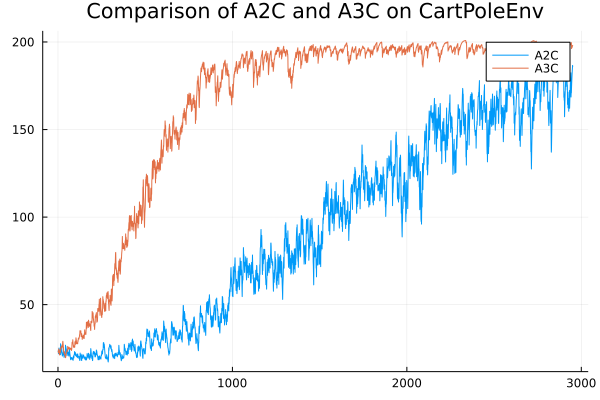

In [202]:
using TimerOutputs

reset_timer!()
num_runs = 3
env_fn = ReinforcementLearning.CartPoleEnv
env = env_fn()
env_nS, env_nA = length(ReinforcementLearning.state(env)), length(ReinforcementLearning.action_space(env))
ac_weights, a2c_avgrewards = main_a2c(env_fn; nS = env_nS, nA = env_nA)
@sync for _ in 1:num_runs
    @timeit "a2c" begin
        main_a2c(env_fn; nS = env_nS, nA = env_nA)
    end
end
a3c_shared_ac_weights, a3c_avgrewards = main_a3c(env_fn; nS = env_nS, nA = env_nA)
@sync for _ in 1:num_runs
    @timeit "a3c" begin
        main_a3c(env_fn; nS = env_nS, nA = env_nA)
    end
end
p = plot(a2c_avgrewards[50:end], title="Comparison of A2C and A3C on CartPoleEnv", label="A2C")
plot!(p, a3c_avgrewards[50:end], label="A3C")


In [203]:
print_timer()

 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      52.2s /  78.4%           36.3GiB /  75.1%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 a3c            3    32.4s   79.2%   10.8s   22.7GiB   83.3%  7.56GiB
 a2c            3    8.50s   20.8%   2.83s   4.56GiB   16.7%  1.52GiB
 ────────────────────────────────────────────────────────────────────
